In [1]:
from IPython import get_ipython

 # Estimating COVID-19's $R_t$ in Real-Time with PYMC3

 Kevin Systrom - April 22

 Model originally built by [Thomas Vladeck](https://github.com/tvladeck) in Stan, parts inspired by the work over at https://epiforecasts.io/, lots of help from [Thomas Wiecki](https://twitter.com/twiecki). Thank you to everyone who helped.

 This notebook is a WIP - I'll add more context and commentary over the coming week.

In [2]:
# For some reason Theano is unhappy when I run the GP, need to disable future warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import os
import requests
import pymc3 as pm
import pandas as pd
import numpy as np
import theano
import theano.tensor as tt
import datetime as dtime

from matplotlib import pyplot as plt
from matplotlib import dates as mdates
from matplotlib import ticker

from datetime import date
from datetime import datetime

from IPython.display import clear_output

get_ipython().run_line_magic('config', "InlineBackend.figure_format = 'retina'")

 BEGIN included locations -------- #

In [3]:
loc_europe_EU = [
	'Austria', 
	'Belgium', 
	'Bulgaria', 
	'Croatia', 
	'Cyprus', 
	'Czech Republic', 
	'Denmark', 
	'Estonia', 
	'Finland', 
	'France', 
	'Germany', 
	'Greece', 
	'Hungary', 
	'Ireland', 
	'Italy', 
	'Latvia', 
	'Lithuania', 
	'Luxembourg', 
	'Malta', 
	'Netherlands', 
	'Poland', 
	'Portugal', 
	'Romania', 
	'Slovakia', 
	'Slovenia', 
	'Spain', 
	'Sweden']

loc_europe_others = [
	'Norway',
	'United Kingdom',
	'Switzerland']

loc_non_europe = [
	'United States',
	'Russia']

ACTIVE_COUNTRIES = list(set(loc_europe_EU + loc_europe_others + loc_non_europe))

# END included locations -------- #

 ### Render to CSV
 Uncomment if you'd like

### Load from CSV

In [4]:
res_file = 'rt_EUW_2020-05-08-0000.csv'
fpath = 'data/' + res_file
results = pd.read_csv(fpath,
                      parse_dates=['date'],
                      index_col=['region', 'date']).sort_index()

#### Prepare layout

In [5]:
import seaborn as sns
rtlive = ["#5db044", "#da5d5d", "#95a5a6", "#e74c3c", "#34495e"]
sns.set_palette(rtlive)

 ### Render Charts

In [6]:
def plot_rt(name, result, ax, c=(.3,.3,.3,1), ci=(0,0,0,.05)):
    ax.set_ylim(0.0, 3.0)
    ax.set_title(name)
    
    m_good = result.copy()
    m_bad = result.copy()
    m_good['median'][m_good['median'] > 1.04] = np.nan
    m_bad['median'][m_bad['median'] <= 0.98] = np.nan
    
    floor = result['lower_90'].copy()
    floor[floor < 1] = 1
    ceiling = result['upper_90'].copy()
    ceiling[ceiling > 1] = 1
    
    ax.plot(m_bad['median'], marker='',ls='-', lw=1.5, color=sns.color_palette()[1])
    ax.plot(m_good['median'], marker='',ls='-', lw=1.5, color=sns.color_palette()[0])

    ax.fill_between(result.index, floor, result['upper_90'].values, 
                    where=(result['upper_90'].values > 1),
                    alpha=0.10, color=sns.color_palette()[1])
    ax.fill_between(result.index, result['lower_90'].values, ceiling, 
                    where=(result['lower_90'].values < 1),
                    alpha=0.10, color=sns.color_palette()[0])
    
    ax.axhline(1.0, linestyle='dotted', lw=2, color=sns.xkcd_rgb["light grey"])
    
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%m/%d'))
    ax.xaxis.set_major_locator(mdates.WeekdayLocator(interval=2))



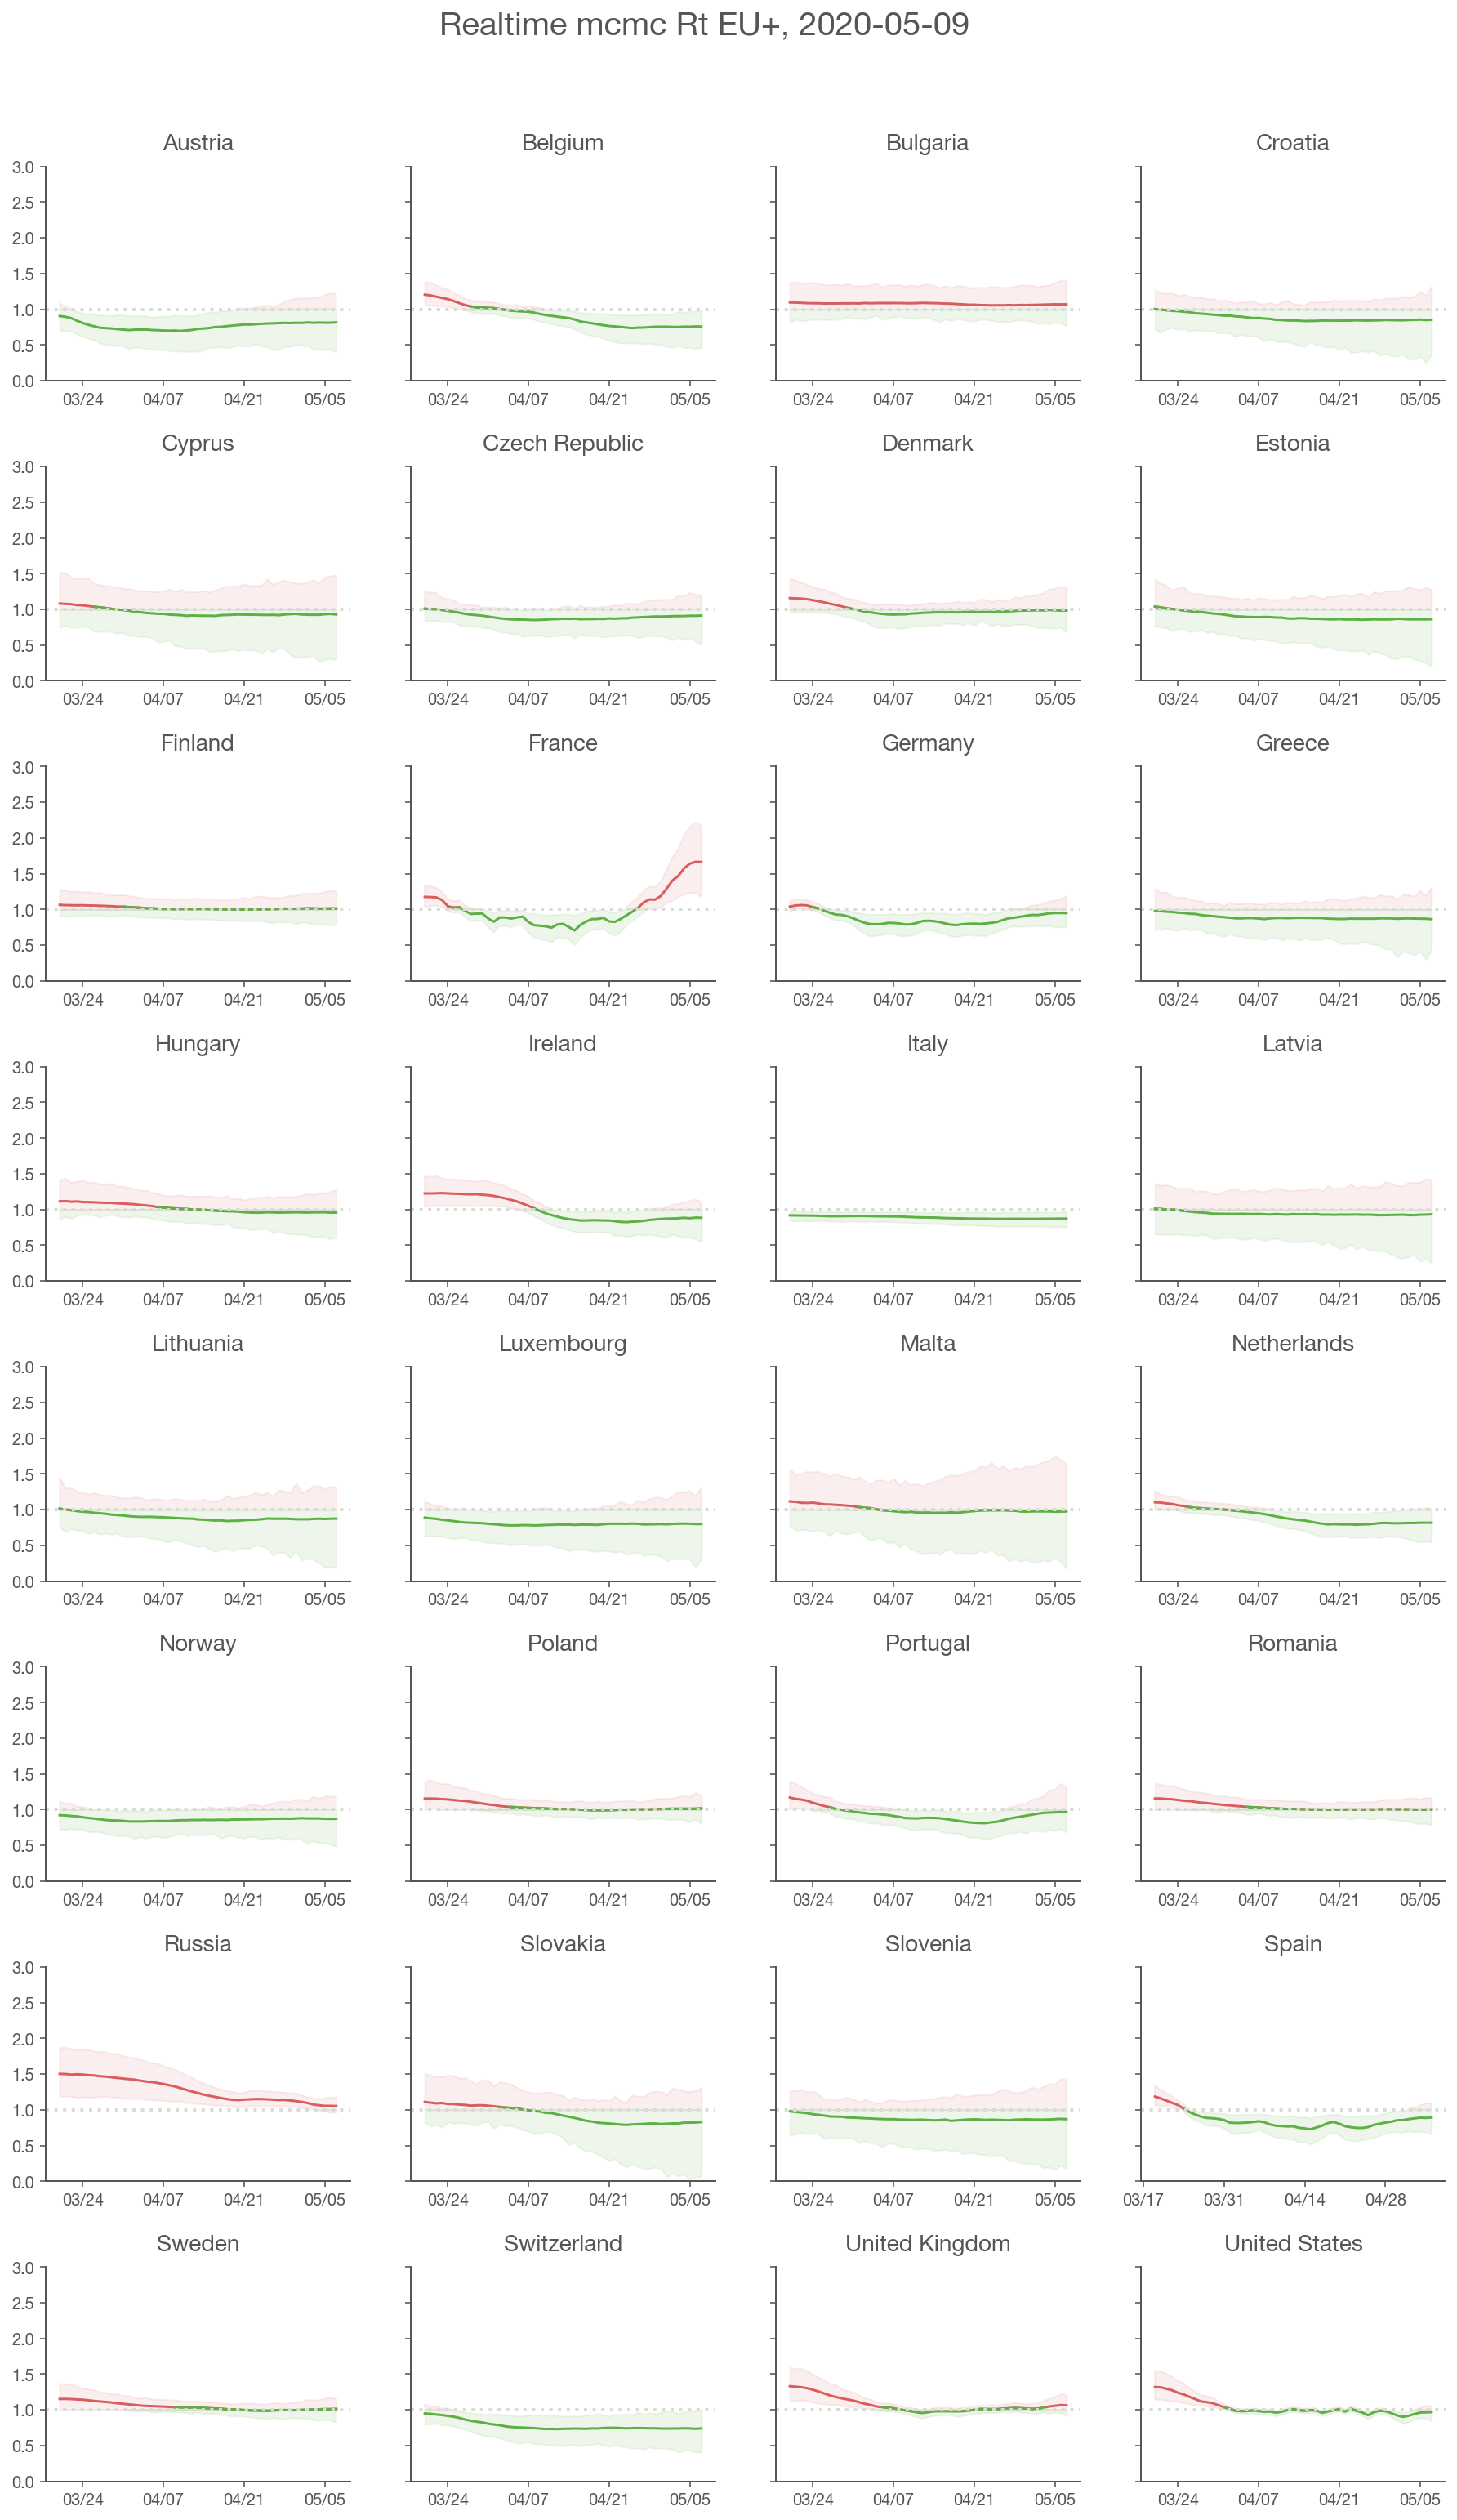

In [7]:
ncols = 4
nrows = int(np.ceil(results.index.levels[0].shape[0] / ncols))

# temporarily limit states for plot testing, set to 0 for unlimited
state_count = 0

fig, axes = plt.subplots(
    nrows=nrows,
    ncols=ncols,
    figsize=(14, nrows*3),
    sharey='row')

count = 0;

for idx, (ax, (state, result)) in enumerate(zip(axes.flatten(), results.groupby('region'))):
    
    if ((state_count != 0) & (count >= state_count)):
        [ax.set_visible(False) for ax in axes.flatten()[idx:]]
        break
    
    plot_rt(state, result.droplevel(0), ax)
    count +=1

else:
    [ax.set_visible(False) for ax in axes.flatten()[idx+1:]]

this_date = datetime(2020, 5, 9).strftime('%Y-%m-%d')
#this_date = datetime.today().strftime('%Y-%m-%d')
fig_title = "Realtime mcmc Rt EU+, " + this_date
fig.suptitle(fig_title, y=0.955, fontsize=20)

#fig.tight_layout()
fig.set_facecolor('w')
plt.subplots_adjust(top=0.90, bottom=0.08, left=0.10, right=0.95, hspace=0.40, wspace=0.2)


